# Theano implementation of Gumbel Softmax / Concrete VAE with BayesFlow

Implements a categorical VAE using the technique introduced in [The Concrete Distribution: A Continuous Relaxation of Discrete Random Variables (Maddison et al. 2016)](https://arxiv.org/abs/1611.00712) and [Categorical Reparameterization with Gumbel-Softmax (Jang et al. 2016)](https://arxiv.org/abs/1611.01144). The VAE architecture shown here are a bit different than the models presented in the papers, this one has 1 stochastic 20x10-ary layer with 2-layer deterministic encoder/decoders and a fixed prior.

Tensorflow version: 17 Feb 2017

Theano version: 22 Aug 2017

In [1]:
import os
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

import theano
from theano import tensor as T

# Helper functions 

These are shared across the Bernoulli, OneHotCategorical, and RelaxedOneHotCategorical distributions

In [2]:
def log_softmax(logits):
    '''
    logsoftmax = logits - log(reduce_sum(exp(logits), dim))
    
    TODO: rewrite to avoid the double transpose
    '''
    return (logits.T - T.log(T.sum(T.exp(logits), -1))).T

def _get_logits_and_probs(logits=None, probs=None, multidimensional=False):
    '''
    Converts logit to probabilities (or vice-versa), and returns both.

    Args:
        logits: Floating-point `Tensor` representing log-odds.

        probs: Floating-point `Tensor` representing probabilities.            

    Returns:
    logits, probs: Tuple of `Tensor`s. If `probs` has an entry that is `0` or
    `1`, then the corresponding entry in the returned logit will be `-Inf` and
    `Inf` respectively.

    Sourced from:
    https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/ops/distributions/util.py
    '''

    if probs is None:
        if multidimensional:
            return logits, T.nnet.softmax(logits)
        return logits, T.nnet.sigmoid(logits)

These are used to weight initialisation and model optimisation

In [ ]:
def Adam(params, grads, lr=0.001, b1=0.9, b2=0.999, e=1e-8):
        updates = []
        i = theano.shared(np.float32(0.))
        i_t = i + 1.
        fix1 = 1. - (1. - b1)**i_t
        fix2 = 1. - (1. - b2)**i_t
        lr_t = lr * (T.sqrt(fix2) / fix1)
        for p, g in zip(params, grads):
            m = theano.shared(p.get_value() * 0.)
            v = theano.shared(p.get_value() * 0.)
            m_t = (b1 * g) + ((1. - b1) * m)
            v_t = (b2 * T.sqr(g)) + ((1. - b2) * v)
            g_t = m_t / (T.sqrt(v_t) + e)
            p_t = p - (lr_t * g_t)
            updates.append((m, m_t))
            updates.append((v, v_t))
            updates.append((p, p_t))
        updates.append((i, i_t))
        return updates

def initOrthoWeights(dim, dim_out, activ=None, name=None):
    '''
    Initialise the weights from scratch
    '''
    if activ == None:
        gain = 1.0
    elif activ == 'relu':
        gain = np.sqrt(2.0)
    mean = 0.0
    std = gain * np.sqrt(2.0 / float((dim + dim_out)))
    a = mean - np.sqrt(3) * std
    b = mean + np.sqrt(3) * std
    W = np.random.uniform(low=a, high=b, size=(dim, dim_out))
    return theano.shared(W, name=name).astype(theano.config.floatX)

def initBias(dims, name=None):
    '''
    Initialise the bias from scratch
    '''
    return theano.shared(np.zeros(dims, dtype=theano.config.floatX), name=name)

# Bernoulli distribution

A bare-bones implementation of the main() and log_prob(event) functions of the Bernoulli distribution

In [3]:
class TBernoulli:
    
    def __init__(self, logits=None, probs=None):
        '''
        logits: An N-D `Tensor` representing the log-odds of a `1` event. Each
        entry in the `Tensor` parametrizes an independent Bernoulli distribution
        where the probability of an event is sigmoid(logits). Only one of
        `logits` or `probs` should be passed in.
        '''
        
        self.logits, self.probs = _get_logits_and_probs(logits, probs)
         
    def mean(self):
        '''
        Returns the self.probs as is.
        '''
        return self.probs
        
    def log_prob(self, labels):
        '''
        Sourced from:
        https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/python/ops/distributions/bernoulli.py#L123
        https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/python/ops/nn_impl.py#L100
        '''
        zeros = T.zeros_like(self.logits)
        cond = (self.logits > zeros)
        relu_logits = T.switch(cond, self.logits, zeros * self.logits)
        neg_abs_logits = T.switch(cond, self.logits * -1, self.logits)
        return - ((relu_logits - self.logits * labels) + T.log(1+T.exp(neg_abs_logits)))

# OneHotCategorical

In [4]:
class TOneHotCategorical:
    
    def __init__(self, logits=None, probs=None):
        '''
        logits: An N-D `Tensor` representing the log-odds of a `1` event. Each
        entry in the `Tensor` parametrizes an independent Bernoulli distribution
        where the probability of an event is sigmoid(logits). Only one of
        `logits` or `probs` should be passed in.
        '''
        
        self.logits, self.probs = _get_logits_and_probs(logits, probs)
                
    def one_hot_categorical_kl_divergence(self, b):
        '''
        Sourced from:
        https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/contrib/distributions/python/ops/onehot_categorical.py#L238
            '''
        
        if self.logits.ndim == 3:
            logits = T.reshape(self.logits,  [-1, self.logits.shape[-1]])
        if b.logits.ndim == 3:
            b = T.reshape(b.logits, [-1, b.logits.shape[-1]])

        kl = T.sum(T.nnet.softmax(logits) * (log_softmax(logits) - log_softmax(b)), -1)
        kl = T.reshape(kl, [-1, self.logits.shape[-2]])
        return kl
    
    def test():
        logits_y = np.load('tests/logits_y.npy')
        logits_py = np.load('tests/logits_py.npy')
        
        x = T.tensor3('x') # input vector
        y = T.tensor3('y') # input vector
        
        cat = TOneHotCategorical(logits=x)
        cat2 = TOneHotCategorical(logits=y)
        kl_f = cat.one_hot_categorical_kl_divergence(cat2)
        f = theano.function([x, y], kl_f)
        
        kl = f(logits_y, logits_py)
        expected_kl = np.load('tests/kl.npy')
               
        assert np.allclose(kl,expected_kl)

# RelaxedOneHotCategorical

A bare-bones implementation of the sample() and logprob(event) functions needed for the Gumbel-Softmax

In [5]:
from theano.tensor.shared_randomstreams import RandomStreams

class TRelaxedOneHotCategorical:
    '''
    An implementation of the Gumbel-Softmax distribution
    '''
    
    def __init__(self, temperature, logits=None, probs=None):
        '''
        logits: An N-D `Tensor` representing the log-odds of a `1` event. Each
        entry in the `Tensor` parametrizes an independent Bernoulli distribution
        where the probability of an event is sigmoid(logits). Only one of
        `logits` or `probs` should be passed in.
        '''
        self.temperature = temperature
        self.logits, self.probs = _get_logits_and_probs(logits, probs)
        self.event_size = self.logits.shape[-1]
        self.srng = RandomStreams()

        
    def _sample_n(self, n):
        '''
        Generate a single sample from the distribution        
        '''
        #sample_shape = T.concatenate([[n], T.ones_like(self.logits)])
        sample_shape = T.shape(T.ones_like(self.logits))
        logits = self.logits * T.ones_like(self.logits)
        logits_2d = T.reshape(logits, [-1, self.event_size])
        # Uniform variates must be sampled from the open-interval `(0, 1)` rather
        # than `[0, 1)`. To do so, we use `np.finfo(self.dtype.as_numpy_dtype).tiny`
        # because it is the smallest, positive, "normal" number. A "normal" number
        # is such that the mantissa has an implicit leading 1. Normal, positive
        # numbers x, y have the reasonable property that, `x + y >= max(x, y)`. In
        # this case, a subnormal number (i.e., np.nextafter) can cause us to sample
        # 0.
        u = self.srng.uniform(logits_2d.shape, low=np.finfo('float32').tiny, high=1.).astype('float32')
        gumbel = -T.log(-T.log(u+ 1e-20) + 1e-20) # 1e-20 controls for NaN and Inf errors
        noisy_logits = (gumbel + logits_2d) / self.temperature       
        samples = T.nnet.softmax(noisy_logits)
        ret = T.reshape(samples, sample_shape)
        return ret
        
    def sample(self, shape=None):
        '''
        Generate samples conforming to the shape argument
        '''
        return self._sample_n(1)
    
    def _inverse_log_det_jacobian(self, x):
        return -1. * T.sum(T.log(x), axis=-1)
    
    def _log_prob(self, x):
        '''
        Helper function that directly calculates the log probability
        '''
        logits = self.logits
        if T.shape(logits) != T.shape(x):
            # ERROR: This doesn't seem to work in TensorFlow either?
            logits = T.ones_like(x, dtype=logits.dtype) * logits
            x = T.ones_like(logits, dtype=x.dtype) * x
        logits_shape = T.shape(T.sum(T.ones_like(logits), axis=-1))
        logits_2d = T.reshape(logits, [-1, self.event_size])
        x_2d = T.reshape(x, [-1, self.event_size])
        k = T.cast(self.event_size, x.dtype)
        log_norm_const = (T.gammaln(k) + (k - 1.) * T.log(self.temperature))
        # compute the unnormalized density
        logsoftmax = log_softmax(logits_2d - x_2d * self.temperature)
        log_unnorm_prob = T.sum(logsoftmax, [-1])
        # combine unnormalized density with normalization constant
        logprob = log_norm_const + log_unnorm_prob
        # Reshapes log_prob to be consistent with shape of user-supplied logits
        ret = T.reshape(logprob, logits_shape)
        return ret
    
    def log_prob(self, x):
        '''
        Calculcate the log probability of the input, under the distribution.
        
        We're following the TransformationDistribution approach from Tensorflow here.
                
        1) log(x)
        2) Calculate _log_prob(log(x))
        3) Calculate _inverse_log_det_jacobian(x)
        4) Return 2) + 3)
        '''
        logx = T.log(x)
        log_prob = self._log_prob(logx)
        ildj = self._inverse_log_det_jacobian(x)
        return log_prob + ildj
    
    def test():
        logits_y = T.dtensor3('logits_y') # logits of y
        logits_py = T.dtensor3('logits_py') 
        y = T.dtensor3('y') # Sample from the G-S
        p_y = TRelaxedOneHotCategorical(logits=logits_py, temperature=1.0)
        q_y = TRelaxedOneHotCategorical(logits=logits_y, temperature=1.0)

        p_y_logprob_y = p_y.log_prob(y)
        q_y_logprob_y = q_y.log_prob(y)
        KL_qp = q_y_logprob_y - p_y_logprob_y
        KL = KL_qp.sum(axis=1)
        
        f1 = theano.function([logits_py, y], p_y_logprob_y)
        f2 = theano.function([logits_y, y], q_y_logprob_y)
        f3 = theano.function([logits_py, logits_y, y], KL_qp)
        f4 = theano.function([logits_py, logits_y, y], KL)

        logits_yval = np.load(open('tests/logits_y.npy', 'rb'))
        logits_pyval = np.load(open('tests/logits_py.npy', 'rb'))
        yval = np.load(open('tests/y.npy', 'rb'))

        # Assert that we can correctly calculate the logprob of y under p_y
        o = f1(logits_pyval, yval)
        check = np.load(open('tests/pylogproby.npy', 'rb'))
        assert np.allclose(o, check)
        
        # Assert that we can correctly calculate the logprob of y under q_y
        o2 = f2(logits_yval, yval)
        check = np.load(open('tests/qylogproby.npy', 'rb'))
        assert np.allclose(o2, check)
        
        # Assert the KL between q_y || p_y
        o3 = f3(logits_pyval, logits_yval, yval)
        check = np.load(open('tests/kl_qp.npy', 'rb'))
        assert np.allclose(o3, check)
        
        # Assert that we sum the KLs correctly
        o4 = f4(logits_pyval, logits_yval, yval)
        check = np.load(open('tests/kl.npy', 'rb'))
        assert np.allclose(o4, check)

# Hyperparameters

In [6]:
batch_size=100
tau0=1.0 # initial temperature
K=10 # number of classes
N=200//K # number of categorical distributions
straight_through=True # if True, use Straight-through Gumbel-Softmax
kl_type='relaxed' # choose between ('relaxed', 'categorical')
max_iters=10000 # Train the model for max_iters
learning_rate = 3e-4 # Optimiser learning rate

# Model Definition

This is a Variational Autoencoder (Kingma et al. (2014)), which aims to learn a semi-supervised generative model.

The latent state is a joint distribution over a Gaussian-style variable Z and a Categorical class variable Y.

The variational lower-bound on the labelled data is a combination of a reconstruction loss log p(x|y,z) and a KL-divergence term KL[q(z|x, y) || p(y)p(z)]

In [7]:
# Parameters for the classification layer
# Two fully connected layers 784 -> 512, 512 -> 256 with RELU activations
Wfc1 = initOrthoWeights(784, 512, activ='relu', name='fc_classifier_1')
fc1b = initBias(512, name='bias_fc1')
Wfc2 = initOrthoWeights(512, 256, activ='relu', name='fc_classifier_2')
fc2b = initBias(256, name='bias_fc2')

# fully-connected layer 256 -> 200 with a linear activation
Woutput = initOrthoWeights(256, K*N, name='fc_classifier_3')
outputb = initBias(K*N, name='bias_fc3')

# Parameters for the reconstruction layer
# Two fully connected layers 200 -> 256, 256->512 with RELU activations
Wrc1 = initOrthoWeights(200, 256, activ='relu', name='recon_1')
rc1b = initBias(256, 'bias_rc1')
Wrc2 = initOrthoWeights(256, 512, activ='relu', name='recon_2')
rc2b = initBias(512, name='bias_rc2')

# Fully-connected layer: 512 -> 784 for predicting the actual pixel values 
Wlogits_x = initOrthoWeights(512, 784, name='recon_3')
logits_xb = initBias(784, name='bias_rc3')

# Learnable parameter for the temperature
tau = theano.shared(tau0, name='tau')

In [8]:
lr = T.scalar('lr')
srng = RandomStreams()
# x is the input data, in this case a raw vector representing the pixels (28x28=784 pixels)
x = T.dmatrix('input_pixels')
x.tag.test_value = np.random.rand(batch_size, 784)
x_noise = srng.uniform(T.shape(x)) * x #dynamic binarization

# Classification model

def classification(x, x_noise, Wfc1, fc1b, Wfc2, fc2b, Woutput, outputb):
    fc1 = T.nnet.relu(T.dot(x_noise, Wfc1) + fc1b)
    fc2 = T.nnet.relu(T.dot(fc1, Wfc2) + fc2b)
    out = T.dot(fc2, Woutput) + outputb
    return out

output = classification(x, x_noise, Wfc1, fc1b, Wfc2, fc2b, Woutput, outputb)

# reshape output into (batch size, N, K) tensor
logits_y = output.reshape((-1, N, K))

# the Gumbel-Softmax distritubion, given the output of the network (logits_y) and the temperature (Eq 2)
# only used if we are not doing a Straight Through Estimator
q_y = TRelaxedOneHotCategorical(tau, logits_y)

# Draw a single sample from the Gumbel-Softmax (Footnote 1)
y = q_y.sample()

if straight_through:
    '''
    We want to (or need to) sample a discrete value for y.
    y_hard = take the argmax of the Gumbel-Softmax distribution y
    y_hard_onehot = transform the hard sample into a one-hot array (K possible values)
    y_hard_onehot = cast into the original data type of y
    '''
    y_hard = T.argmax(y, axis=-1)
    y_hard_onehot = T.eye(K)[y_hard] # Cast the hard samples into a 1-hot encoding
    y = theano.gradient.zero_grad(y_hard_onehot - y) + y # Prevent gradient flow
    
y_flat = T.reshape(y, (-1, K*N))

def reconstruction(y_flat, Wrc1, rc1b, Wrc2, rc2b, Wlogits_x, logits_xb):
    # Convert the sample drawn from the G-S into a single vector instead of a matrix
    rc1 = T.nnet.relu(T.dot(y_flat, Wrc1) + rc1b)
    rc2 = T.nnet.relu(T.dot(rc1, Wrc2) + rc2b)
    out2 = T.dot(rc2, Wlogits_x) + logits_xb
    return out2

logits_x = reconstruction(y_flat, Wrc1, rc1b, Wrc2, rc2b, Wlogits_x, logits_xb)

# Each pixel is drawn from a Bernoulli, given the predictions of the model (logits_x)
p_x = TBernoulli(logits=logits_x)

#Mean predicted pixel value
x_mean = p_x.mean()

# Calculcate the log probability of the predicted pixel values
recons = T.sum(p_x.log_prob(x), axis=1)

# Create a vector of 1s and mulitply through by 1/K
logits_py = T.ones_like(logits_y) * 1./K

# Calculcate the KL-Divergence between either a pair of hard categorical predictions or the G-S disributions
if kl_type=='categorical' or straight_through:
    # Analytical KL with Categorical prior
    p_cat_y = TOneHotCategorical(logits=logits_py)
    q_cat_y = TOneHotCategorical(logits=logits_y)
    KL_qp = q_cat_y.one_hot_categorical_kl_divergence(p_cat_y)
else:
    # Monte Carlo KL with Relaxed prior
    # TODO: Why does the KL term result in no learning
    p_y = TRelaxedOneHotCategorical(tau, logits=logits_py)
    KL_qp = q_y.log_prob(y) - p_y.log_prob(y)
        
# Calculcate the KL-divergence for each pair of distributions in the batch
KL = KL_qp.sum(1)
#Calculcate the mean batch KL-divergence
mean_KL = T.mean(KL)
# Calculcate the mean batch reconstruction loss
mean_recons = T.mean(recons)
# Our loss is to reduce the negative of the (Reconstruction loss - KL-divergence)
# This is Equation 8.
loss = -T.mean(recons - KL)

In [9]:
# Define how we will train the model
params = [Wfc1, fc1b, Wfc2, fc2b, Woutput, outputb, tau, Wrc1, rc1b, Wrc2, rc2b, Wlogits_x, logits_xb]

gradients = T.grad(loss, params)

train = theano.function(inputs=[x, lr],
                             outputs=[loss, mean_recons, mean_KL, tau],
                             updates=Adam(params, gradients, lr))

predict = theano.function(inputs=[x], 
                               outputs=x_mean, 
                               allow_input_downcast=True)

In [10]:
# black-on-white MNIST (harder to learn than white-on-black MNIST)
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

data = []
for i in range(1, max_iters):
    batch = mnist.train.next_batch(batch_size)
    result = train(batch[0], learning_rate)
    if i % 100 == 1:
        data.append([i]+[result])
    if i % 1000 == 1:
        print('Step %d, Loss: %0.3f' % (i, result[0]))
print('Step %d, Loss: %0.3f' % (i, result[0]))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Step 1, Loss: 549.425
Step 1001, Loss: 152.291
Step 2001, Loss: 141.907
Step 3001, Loss: 141.677
Step 4001, Loss: 138.255
Step 5001, Loss: 140.481
Step 6001, Loss: 137.208
Step 7001, Loss: 135.601
Step 8001, Loss: 143.852
Step 9001, Loss: 127.386
Step 9999, Loss: 127.510


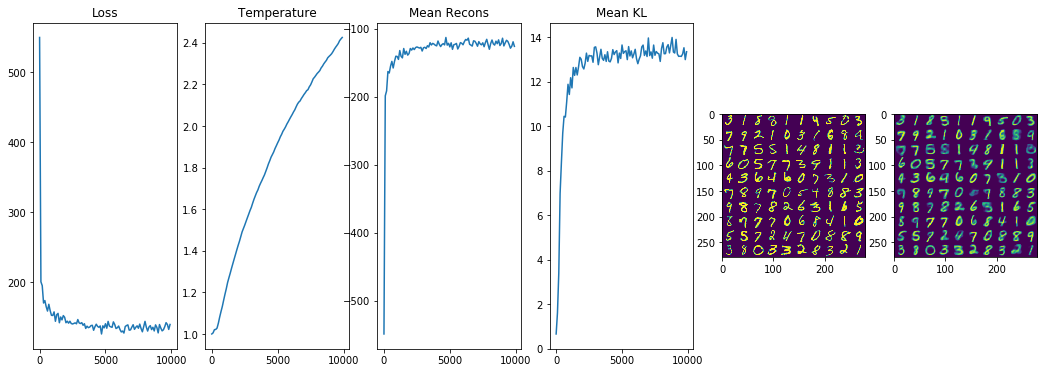

In [11]:
# end training - do an evaluation step
batch = mnist.test.next_batch(batch_size)
np_x = predict(batch[0])

f,axarr=plt.subplots(1,6,figsize=(18,6))

# Plot the loss curve
axarr[0].plot([x[0] for x in data],[x[1][0] for x in data])
axarr[0].set_title('Loss')

# Plot Tau
axarr[1].plot([x[0] for x in data],[x[1][3] for x in data])
axarr[1].set_title('Temperature')

# Plot the reconstruction error
axarr[2].plot([x[0] for x in data],[x[1][1] for x in data])
axarr[2].set_title('Mean Recons')

# Plot the KL
axarr[3].plot([x[0] for x in data],[x[1][2] for x in data])
axarr[3].set_title('Mean KL')

# Plot the true inputs for comparison sake
tmp = np.reshape(batch[0], (-1,280,28))
img = np.hstack([tmp[i] for i in range(10)])
axarr[4].imshow(img)

# Plot the reconstructions
tmp2 = np.reshape(np_x,(-1,280,28)) # (10,280,28)
img2 = np.hstack([tmp2[i] for i in range(10)])
axarr[5].imshow(img2)
plt.grid('off')
plt.show()